In [1]:

import numpy as np
from numpy.random import choice
import matplotlib.pyplot as plt
from matplotlib.pyplot import subplots
from matplotlib.cm import get_cmap
from pickle import dump, load
import scipy as sp
from scipy.integrate import solve_ivp
import time
from tqdm import tqdm
from scipy.optimize import minimize
import scipy as sp
from scipy.integrate import solve_ivp

from numpy.linalg import eig

In [2]:
import os
if 'inference-from-testing' in os.getcwd():
    os.chdir("../..")
os.getcwd()

'/home/research/irenegm/covid-19-in-households-public-master'

In [3]:
from copy import deepcopy
from numpy import arange, array, atleast_2d, log
from os import mkdir
from os.path import isdir, isfile
from pickle import load, dump
from pandas import read_csv
from scipy.integrate import solve_ivp
from model.preprocessing import ( estimate_beta_ext, estimate_growth_rate,
        SEIRInput, HouseholdPopulation, make_initial_condition_by_eigenvector)
from model.specs import SINGLE_AGE_SEIR_SPEC_FOR_FITTING, SINGLE_AGE_UK_SPEC
from model.common import SEIRRateEquations
from model.imports import FixedImportModel

In [4]:
# Use a random seed for reproducibility

np.random.seed(637)

In [5]:
DOUBLING_TIME = 3
growth_rate = log(2) / DOUBLING_TIME

comp_dist = read_csv(
    'inputs/england_hh_size_dist.csv',
    header=0).to_numpy().squeeze()
comp_dist = comp_dist[:3]
comp_dist[:2] *= 0
comp_dist = comp_dist/sum(comp_dist)
max_hh_size = len(comp_dist)
composition_list = np.atleast_2d(arange(1, max_hh_size+1)).T

#comp_dist = array([1.])
#composition_list = array([[1]])

if isdir('outputs') is False:
    mkdir('outputs')
if isdir('outputs/inference-from-testing') is False:
    mkdir('outputs/inference-from-testing')

SPEC = {**SINGLE_AGE_SEIR_SPEC_FOR_FITTING, **SINGLE_AGE_UK_SPEC}
base_sitp = SPEC["SITP"]
SPEC["SITP"] = 1 - (1-base_sitp)**3
model_input_to_fit = SEIRInput(SPEC, composition_list, comp_dist)
household_population_to_fit = HouseholdPopulation(
    composition_list, comp_dist, model_input_to_fit)
beta_ext = 0.
model_input = deepcopy(model_input_to_fit)
model_input.k_ext *= beta_ext

true_density_expo = model_input.density_expo


# With the parameters chosen, we calculate Q_int:
household_population = HouseholdPopulation(
    composition_list, comp_dist, model_input)

true_lam = 3.
pop_prev = 1e-2
rhs = SEIRRateEquations(model_input, household_population, FixedImportModel(4,1, np.array([true_lam * pop_prev])))

H0 = np.zeros((household_population.total_size),)
all_sus = np.where(np.sum(rhs.states_exp_only + rhs.states_inf_only + rhs.states_rec_only, 1)<1e-1)[0]
one_inf = np.where((np.abs(np.sum(rhs.states_inf_only, 1) - 1)<1e-1) & (np.sum(rhs.states_exp_only + rhs.states_rec_only, 1)<1e-1))[0]
H0[all_sus] = 0.99 * comp_dist
H0[one_inf] = 0.01 * comp_dist
S0 = H0.T.dot(household_population.states[:, ::4])
E0 = H0.T.dot(household_population.states[:, 1::4])
I0 = H0.T.dot(household_population.states[:, 2::4])
R0 = H0.T.dot(household_population.states[:, 3::4])
start_state = (1/model_input.ave_hh_size) * array([S0.sum(),
                                                   E0.sum(),
                                                   I0.sum(),
                                                   R0.sum()])
tspan = (0.0, 365)
print("(S,E,I,R)(0)=",start_state)

Estimated beta_int= 0.09059414542908219 , estimated density= 0.7302377020497174
(S,E,I,R)(0)= [0.99666667 0.         0.00333333 0.        ]


In [6]:
# Now set up evaluation time points and solve system:

# New time at which we evaluate the infection
trange = np.arange(0,7*12,7) # Evaluate for 12 weeks

# Solve:
solution = solve_ivp(rhs, tspan, H0, first_step=0.001, atol=1e-16, t_eval=trange)

T = solution.t
H = solution.y
S = H.T.dot(household_population.states[:, ::4])
E = H.T.dot(household_population.states[:, 1::4])
I = H.T.dot(household_population.states[:, 2::4])
R = H.T.dot(household_population.states[:, 3::4])

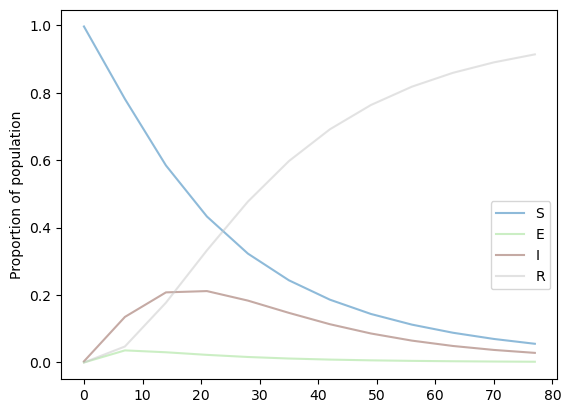

In [7]:
data_list = [S/model_input.ave_hh_by_class,
    E/model_input.ave_hh_by_class,
    I/model_input.ave_hh_by_class,
    R/model_input.ave_hh_by_class]

lgd=['S','E','I','R']

fig, (axis) = subplots(1,1, sharex=True)

cmap = get_cmap('tab20')
alpha = 0.5
for i in range(len(data_list)):
    axis.plot(
        T, data_list[i], label=lgd[i],
        color=cmap(i/len(data_list)), alpha=alpha)
axis.set_ylabel('Proportion of population')
axis.legend(ncol=1, bbox_to_anchor=(1,0.50))

In [8]:
H[H<0.0] = 0.0

Make test data for single-household trajectories and calculate LLH

In [9]:
from numpy.random import choice

H0 = make_initial_condition_by_eigenvector(growth_rate, model_input, household_population, rhs, 1e-1, 0.0,False,3)
test_times = np.arange(7,7*12,7)
def generate_single_hh_test_data(test_times):
    Ht = deepcopy(H0)
    test_data = np.zeros((len(test_times),))
    for i in range(len(test_times)-1):
        tspan = (test_times[i], test_times[i+1])
        solution = solve_ivp(rhs, tspan, Ht, first_step=0.001, atol=1e-16)
        T = solution.t
        H = solution.y
        state = choice(range(len(H[:, -1])), 1, p=H[:, -1]/sum(H[:, -1]))
        test_data[i] = rhs.states_inf_only[state]
        Ht *= 0
        Ht[state] = 1
    return(test_data)
sample_data = generate_single_hh_test_data(test_times)
print(sample_data)

[1. 0. 0. 1. 1. 0. 0. 0. 0. 0. 0.]


In [10]:
# Log likelihood if we can only measure infecteds
# This is for test results from one household, you´ll need to adapt to multiple

def llh_from_test_data(test_data, test_ts, rhs, H0):
    Ht = deepcopy(H0)
    llh = 0
    for i in range(len(test_times)-1):
        if i==0:
            start_time = 0
        else:
            start_time = test_times[i-1]
        tspan = (start_time, test_times[i])
        solution = solve_ivp(rhs, tspan, Ht, first_step=0.001, atol=1e-16)
        T = solution.t
        H = solution.y
        I = test_data[i]
        possible_states = np.where(np.abs(np.sum(rhs.states_inf_only,1)-I)<1e-1)[0]
        llh += np.log(np.sum(H[possible_states, -1]))
        Ht *= 0
        Ht[possible_states] = H[possible_states, -1]
    return(llh)

llh_from_test_data(sample_data, test_times, rhs, H0)

-44.541257424859964

Quick check to make sure the restricted trajectory locks on to the right thing:

In [11]:
# Log likelihood calculation but return probability trajectory

def llh_with_traj(test_data, test_times, rhs, H0):
    Ht = deepcopy(H0)
    H_all = np.atleast_2d(deepcopy(H0)).T
    t_all = np.array(0)
    llh = 0
    for i in range(len(test_times)):
        if i==0:
            start_time = 0
        else:
            start_time = test_times[i-1]
        tspan = (start_time, test_times[i])
        solution = solve_ivp(rhs, tspan, Ht, first_step=0.001, atol=1e-16)
        T = solution.t
        H = solution.y
        I = test_data[i]
        possible_states = np.where(np.abs(np.sum(rhs.states_inf_only,1)-I)<1e-1)[0]
        llh += np.log(np.sum(H[possible_states, -1]))
        Ht *= 0
        Ht[possible_states] = H[possible_states, -1]
        Ht = Ht/sum(Ht)
        H_all = np.hstack((H_all, H))
        t_all = np.hstack((t_all, T))
    return(llh, H_all, t_all)

llh, H_all, t_all = llh_with_traj(sample_data, test_times, rhs, H0)

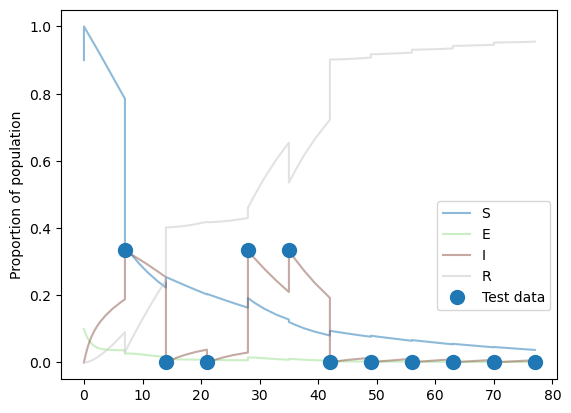

In [12]:
S = H_all.T.dot(household_population.states[:, ::4])
E = H_all.T.dot(household_population.states[:, 1::4])
I = H_all.T.dot(household_population.states[:, 2::4])
R = H_all.T.dot(household_population.states[:, 3::4])

data_list = [S/model_input.ave_hh_by_class,
    E/model_input.ave_hh_by_class,
    I/model_input.ave_hh_by_class,
    R/model_input.ave_hh_by_class]

lgd=['S','E','I','R', "Test data"]

fig, (axis) = subplots(1,1, sharex=True)

cmap = get_cmap('tab20')
alpha = 0.5
for i in range(len(data_list)):
    axis.plot(t_all,
        data_list[i], label=lgd[i],
        color=cmap(i/len(data_list)), alpha=alpha)
axis.plot(test_times, sample_data/model_input.ave_hh_by_class, marker=".", ls="", ms=20, label=lgd[-1])
axis.set_ylabel('Proportion of population')
axis.legend(ncol=1, bbox_to_anchor=(1,0.50))

In [13]:
# Now do multiple households

# Generate test data:
n_hh = 200
multi_hh_data = [
    data for data in (generate_single_hh_test_data(test_times) for _ in range(n_hh))
    if data[0] == 0
]

Have a look at the household data:

In [14]:
multi_hh_data

[array([0., 0., 1., 2., 1., 1., 0., 0., 0., 0., 0.]),
 array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
 array([0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.]),
 array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
 array([0., 0., 1., 0., 1., 1., 1., 1., 1., 1., 0.]),
 array([0., 0., 0., 0., 2., 0., 0., 0., 0., 0., 0.]),
 array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
 array([0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0.]),
 array([0., 0., 2., 0., 0., 0., 0., 0., 0., 1., 0.]),
 array([0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.]),
 array([0., 0., 0., 0., 0., 1., 1., 1., 0., 0., 0.]),
 array([0., 1., 2., 1., 1., 1., 1., 0., 0., 0., 0.]),
 array([0., 0., 0., 0., 0., 0., 0., 2., 2., 1., 0.]),
 array([0., 0., 0., 0., 1., 2., 2., 0., 0., 0., 0.]),
 array([0., 0., 0., 0., 0., 0., 2., 1., 1., 0., 0.]),
 array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
 array([0., 0., 0., 0., 1., 2., 1., 1., 0., 0., 0.]),
 array([0., 1., 1., 2., 1., 0., 0., 0., 0., 0., 0.]),
 array([0., 0., 2., 1., 0., 

In [15]:
# Find the time of the first infection for each household
first_infection_times = []

for data in multi_hh_data:
    for time, infected in zip(test_times, data):
        if infected > 0:
            first_infection_times.append(time)
            break


In [17]:
# Calculate the mean time of the first infection
if first_infection_times:
    mean_first_infection_time = np.mean(first_infection_times)
else:
    mean_first_infection_time = None  # Handle the case where no infections occur

print("Mean time of the first infection: {mean_first_infection_time}")

Mean time of the first infection: {mean_first_infection_time}


In [19]:
# Calculate the frequency of first infection times
from collections import Counter

first_infection_counter = Counter(first_infection_times)

In [47]:
# Calculate the probabilities
total_households = len(first_infection_times)
first_infection_probabilities = {time: count / total_households for time, count in first_infection_counter.items()}

In [23]:
# Display the probabilities per week/7
for time in sorted(first_infection_probabilities.keys()):
    print(f"Time {time}: Probability {first_infection_probabilities[time]:.4f}")

Time 14: Probability 0.2941
Time 21: Probability 0.2588
Time 28: Probability 0.1059
Time 35: Probability 0.0941
Time 42: Probability 0.0824
Time 49: Probability 0.0353
Time 56: Probability 0.0824
Time 63: Probability 0.0235
Time 70: Probability 0.0235


In [70]:
first_inf_prob_array = np.array([.2941, .2588, .1059, .0941, .0824, .0353, .0824, .0235, .0235])

0.9999999999999999

In [29]:
# Find the maximum likelihood estimate
if first_infection_probabilities:
    mle_time = max(first_infection_probabilities, key=first_infection_probabilities.get)
    mle_probability = first_infection_probabilities[mle_time]
else:
    mle_time = None
    mle_probability = None

print("Maximum likelihood estimate for the first infection time:",mle_time," with probability, ",mle_probability)

Maximum likelihood estimate for the first infection time: 14  with probability,  0.29411764705882354


In the next box we calculate the mean of a geometric distribution describing the waiting time to first event in a Poisson process for first infection in the household.

In [34]:
mean_inf_time = np.mean(first_infection_times)

Based on this work out proportion of first infections to be seen each week we would see if it was a true Poisson process:

In [75]:
from scipy.stats import geom

estimated_inf_dist = [geom.cdf(T, 1/mean_inf_time) - geom.cdf(T-7, 1/mean_inf_time) for T in sorted(first_infection_probabilities.keys())]

Plot them for comparison (red is true first infections, green is geometric)

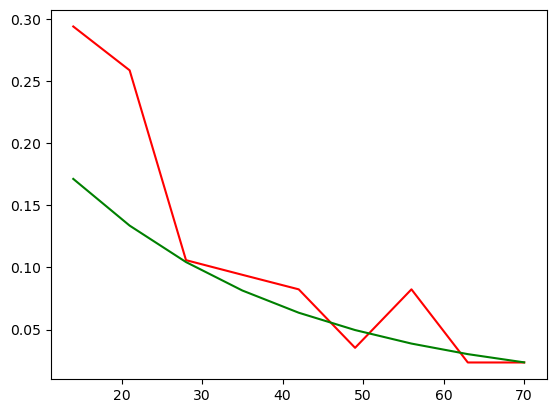

In [77]:
fig, ax = subplots(1, 1)
ax.plot(sorted(first_infection_probabilities.keys()), first_inf_prob_array, "r")
ax.plot(sorted(first_infection_probabilities.keys()), estimated_inf_dist, "g")

To do:
* put the geometric parameter `1/mean_inf_time` into the log formula we derived last week to get an estimate for lambda
* repeat the analysis for the opposite extreme where we assume all cases come from external imports, i.e. fit a Poisson process where every case is a "ping" from this process. The equivalent of `1/mean_inf_time` here will be the mean time of *all* postives, not just the first.

In [98]:
# Calculate the rate of infection for each household
infection_rates = []

for data in multi_hh_data:
    infected_counts = np.array(data)
    infection_times = test_times[infected_counts > 0]
    infected_counts = infected_counts[infected_counts > 0]
    if len(infection_times) > 1:
        infection_diffs = np.diff(infection_times)
        infected_diffs = np.diff(infected_counts)
        rates = infected_diffs / infection_diffs
        positive_rates = rates[rates > 0]  # Filter out negative rates
        if len(positive_rates) > 0:
            mean_rate = np.mean(positive_rates)
            infection_rates.append(mean_rate)

In [99]:
# Calculate the overall average rate of infection (lambda)
lambda_rate = np.mean(infection_rates)
print(f"Estimated infection rate (lambda): {lambda_rate:.4f} infections per unit time")

Estimated infection rate (lambda): 0.1347 infections per unit time
